In [458]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

tesla_data = pd.read_csv("historical stock data/tesla_data.csv")


In [460]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [462]:
#reverse the rows and reset index
tesla_data = tesla_data.iloc[::-1].reset_index(drop=True)

In [464]:
#reading the date column by converting to date time format
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

In [466]:
# Columns to be cleaned
columns_to_clean = ['Open', 'Close/Last', 'High', 'Low']

# Remove dollar signs and convert to numeric for each specified column
for column in columns_to_clean:
    tesla_data[column] = tesla_data[column].astype(str).str.replace('[$,]', '', regex=True)
    tesla_data[column] = pd.to_numeric(tesla_data[column], errors='coerce')
tesla_data.head()


,Close/Last,Volume,Open,High,Low
Date,,,,,
2014-07-11,14.5420,49491275,14.7073,14.7733,14.5067
2014-07-14,15.1133,107969721,14.6660,15.2527,14.3634
2014-07-15,14.6387,85719122,15.1153,15.1767,14.5400
2014-07-16,14.4773,60625005,14.7880,14.9867,14.4547
2014-07-17,14.3600,69712720,14.4107,14.7033,14.2400


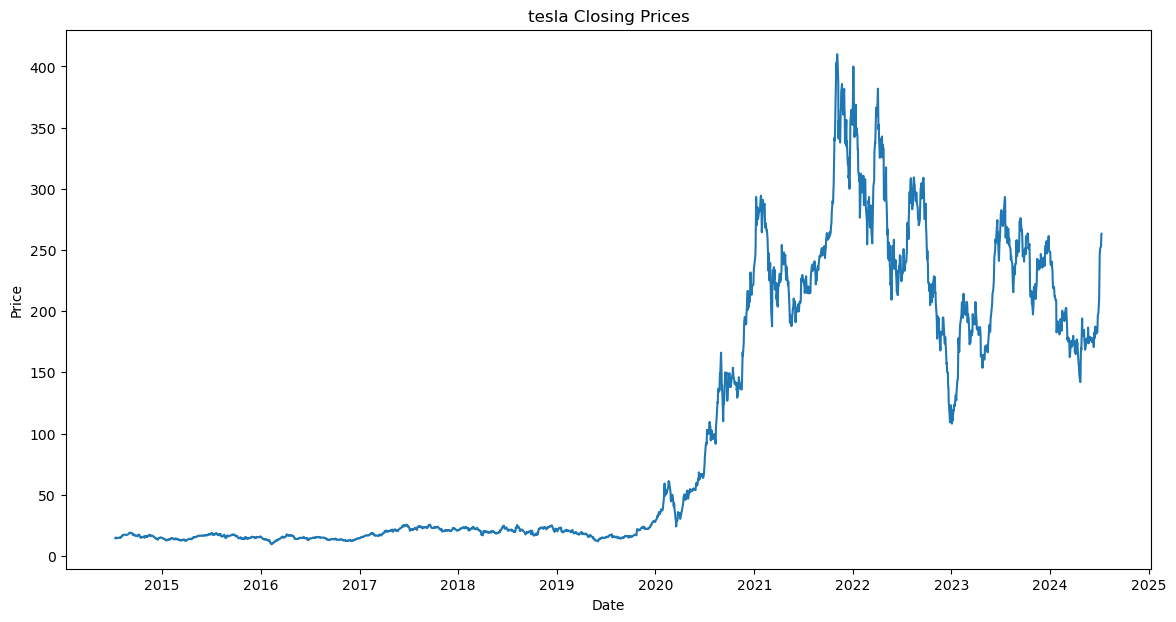

In [468]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Close/Last'])
plt.title('tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

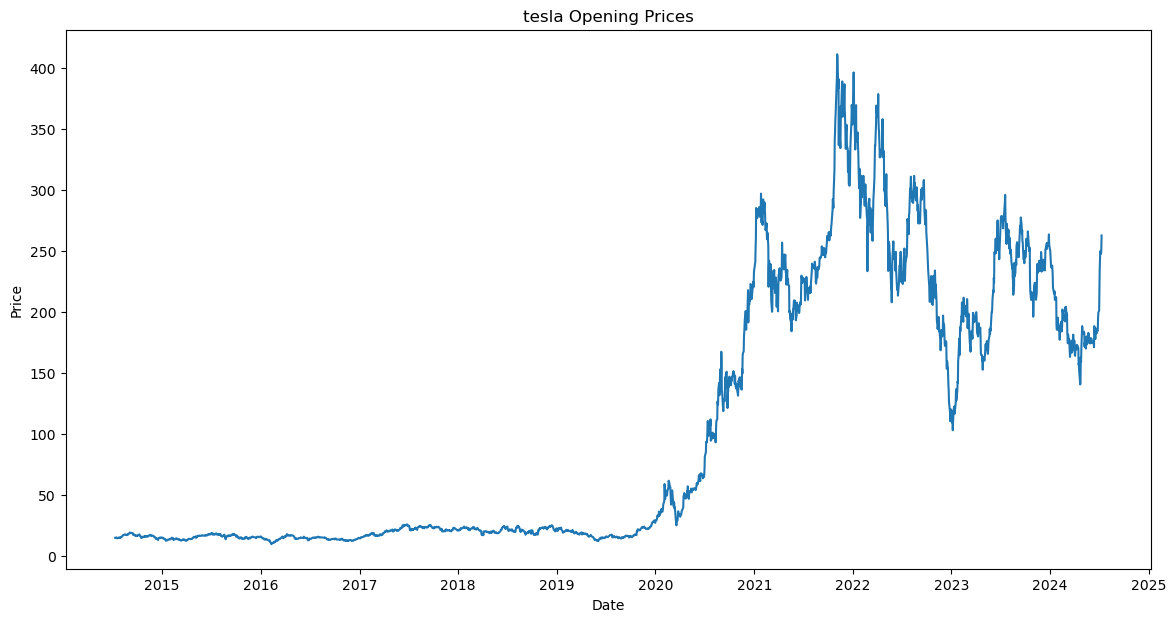

In [469]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Open'])
plt.title('tesla Opening Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

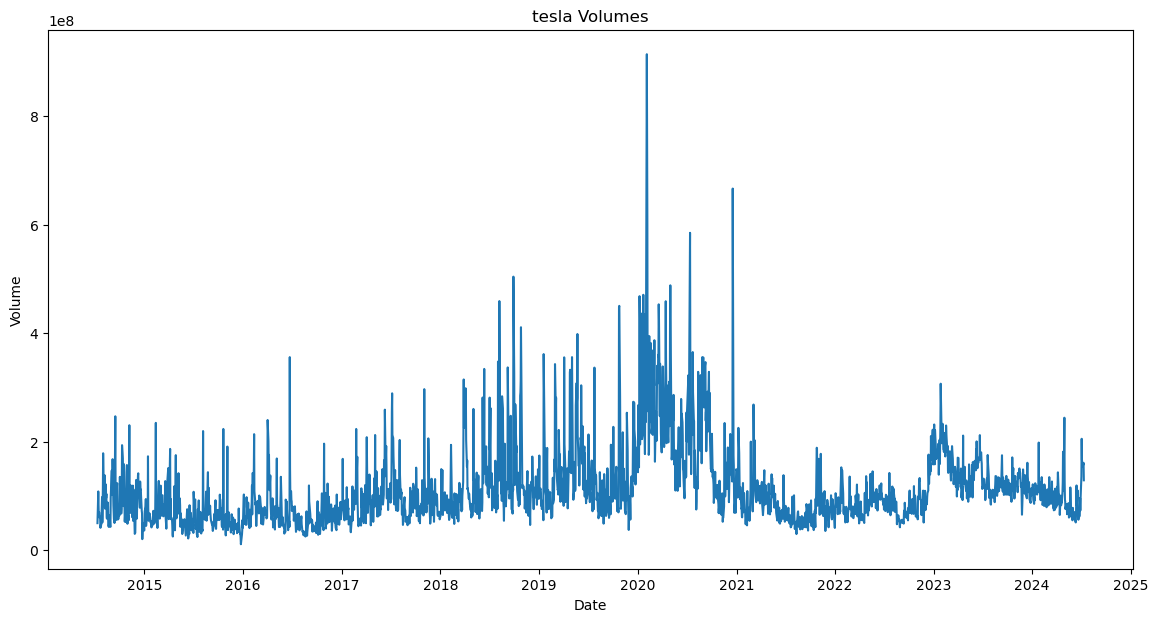

In [471]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Volume'])
plt.title('tesla Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1400x700 with 0 Axes>

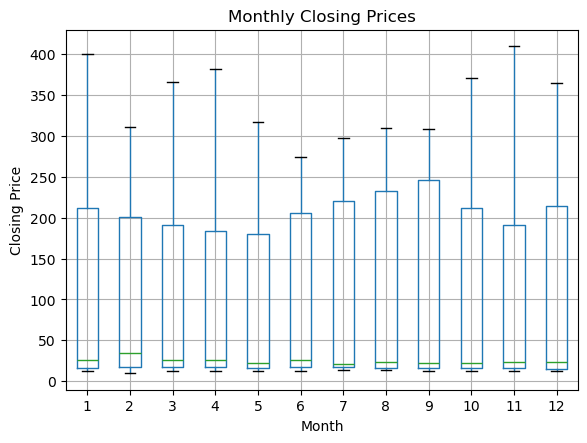

In [474]:
tesla_data['Month'] = tesla_data.index.month
plt.figure(figsize=(14, 7))
tesla_data.boxplot(column='Close/Last', by='Month')
plt.title('Monthly Closing Prices')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.show()

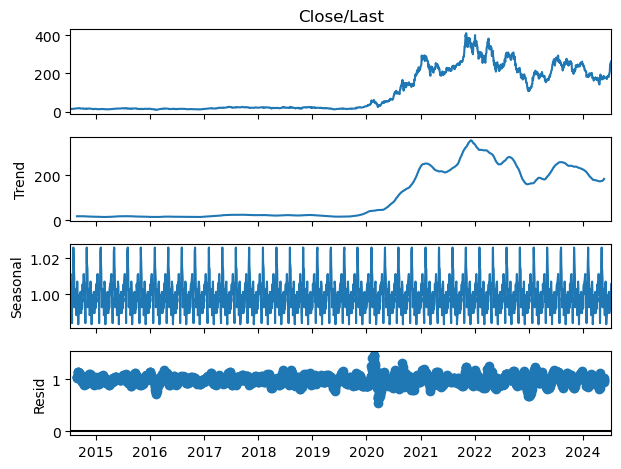

In [476]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tesla_data['Close/Last'], model='multiplicative', period=63)  # Assuming 252 trading days in a year

result.plot()
plt.show()

In [478]:
tesla_data.drop(columns=['Month'], inplace=True)

In [481]:
# Define training data length and keeping 500 testing data 
training_data_len = 2016

# Split the data into training and test sets
train_data = tesla_data.iloc[:training_data_len]
test_data = tesla_data.iloc[training_data_len:]

# Features (X) and target (y)
X_train = train_data[['Close/Last']]
y_train = train_data['Close/Last'].shift(-1).dropna()  # Predict the next day's Close/Last

X_test = test_data[['Close/Last']]
y_test = test_data['Close/Last'].shift(-1).dropna()


In [483]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Adjust y_train and y_test accordingly if you've dropped rows
y_train = y_train[:len(X_train)]
y_test = y_test[:len(X_test)]


C:\Users\harsh\AppData\Local\Temp\ipykernel_5648\2435750949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace=True)
C:\Users\harsh\AppData\Local\Temp\ipykernel_5648\2435750949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.dropna(inplace=True)


In [485]:
# Define features (X) and target (y)
X_train = train_data[['Close/Last', 'Volume']][:-1]  # Drop the last row to match y_train length
y_train = train_data['Close/Last'].shift(-1).dropna()  # Shift target variable to predict the next day

X_test = test_data[['Close/Last', 'Volume']][:-1]  # Drop the last row to match y_test length
y_test = test_data['Close/Last'].shift(-1).dropna()  # Shift target variable to predict the next day


In [487]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [489]:
# Predict on the test set
predictions = rf_model.predict(X_test)


In [491]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predictions)

# Print the evaluation metrics
print(f'MSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape:.2f}%')



MSE: 134.93804354222223
MAE: 9.0389259519038
MAPE: 4.53%


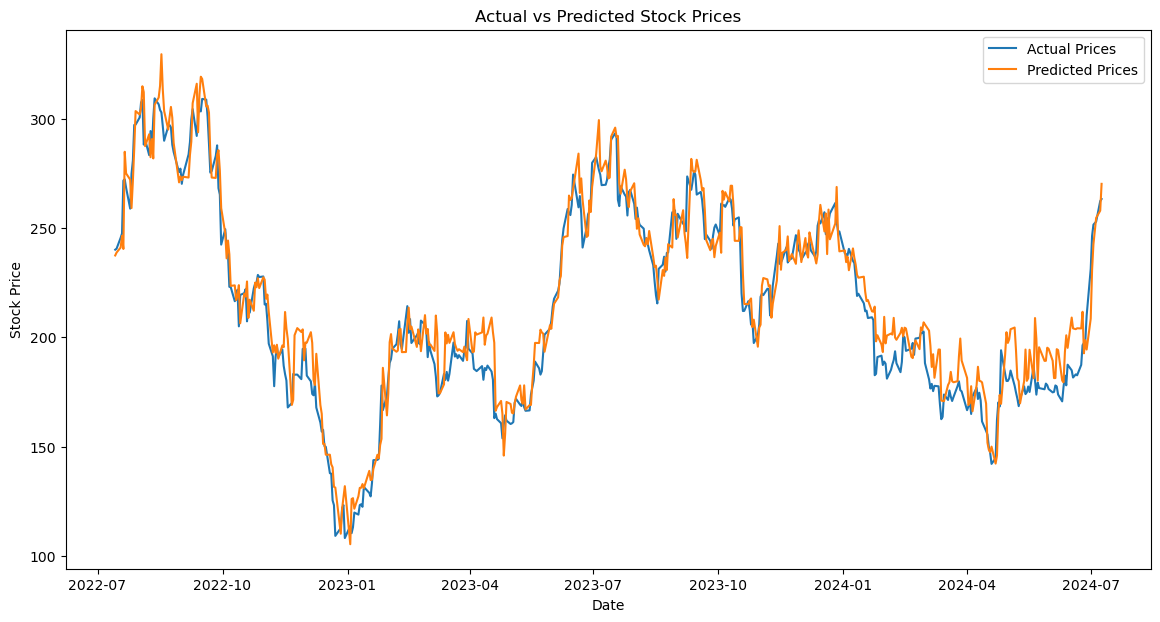

In [493]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [495]:
# Get the actual prices
actual_prices = tesla_data['Close/Last'][training_data_len:].values
# Adjust the valid DataFrame to match the length of predictions
valid = tesla_data[training_data_len+1:].copy()
valid['Predictions'] = predictions
valid

,Close/Last,Volume,Open,High,Low,Predictions
Date,,,,,,
2022-07-15,240.0666,69683017,240.0000,243.6233,236.8900,237.426611
2022-07-18,240.5466,82537448,244.9366,250.5166,239.6033,238.764719
2022-07-19,245.5300,80890118,245.0000,247.1400,236.9766,241.083160
2022-07-20,247.5000,88864089,246.7833,250.6633,243.4830,246.395799
2022-07-21,271.7066,142032194,255.1066,273.2666,254.8666,240.404659
...,...,...,...,...,...,...
2024-07-03,246.3900,166561500,234.5600,248.3500,234.2500,230.696043
2024-07-05,251.5200,154501200,249.8100,252.3700,242.4601,242.553589
2024-07-08,252.9400,157219600,247.7100,259.4390,244.5700,254.605361


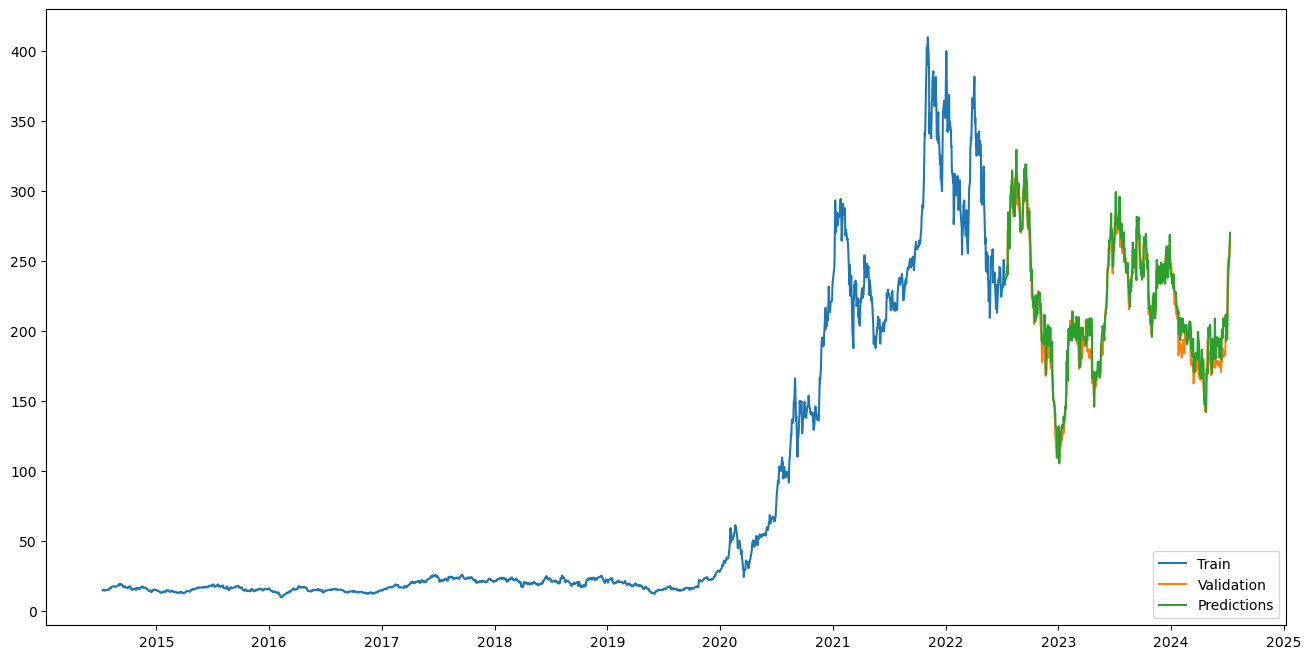

In [497]:
# Plot the results
train = tesla_data[:training_data_len]

plt.figure(figsize=(16,8))
plt.plot(train['Close/Last'], label='Train')
plt.plot(valid[['Close/Last']], label='Validation')
plt.plot(valid[['Predictions']], label='Predictions') 
plt.legend(loc='lower right')
plt.show()